In [1]:
# Reload other .py files without having to restart the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import kagglehub, pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Make sure API token is stored in .kaggle/kaggle.json
# Download latest version
MAIN_PATH = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")
print("Path to dataset files:", MAIN_PATH)

Path to dataset files: C:\Users\Nicholas\.cache\kagglehub\datasets\rhammell\ships-in-satellite-imagery\versions\9


In [3]:
df = pd.read_json(os.path.join(MAIN_PATH, 'shipsnet.json'))
df.head()

data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007

In [4]:
# According to the kaggle page, each sample is stored in a (80*80*3,) array where the first 6400
# values are the red channel of the image stored in row-major order, so the first 80 values are the 
# top row of the red channel. Could just load this from the image itself but I'm feeling goofy
# so we're gonna do it the stupid way.

# Convert the data to an array and get a Series as output
numpySeries = df['data'].apply(np.array) # similar to map(func, iterable)
print(numpySeries.shape)

# Stack all the data along axis 0. Remember that axis 0 is actually the vertical direction
arr = np.stack(numpySeries, axis=0)
print(arr.shape)

# Reshape in Fortran order where the first index changes fastest. 
# We will read 80 reds of the first row
# We will then read 80 of those red columns meaning we traversed 6400 values total
# Finally, we will go to the next axis index to start the green channel.
images = np.reshape(arr, (-1, 80, 80, 3), order='F')
print(images.shape)

# Didn't realize this at the time, but we can just reshape each element in place if we wanted
# df['data'] = df['data'].apply(lambda x: np.reshape(np.array(x), (80, 80, 3), order='F'))

(4000,)
(4000, 19200)
(4000, 80, 80, 3)


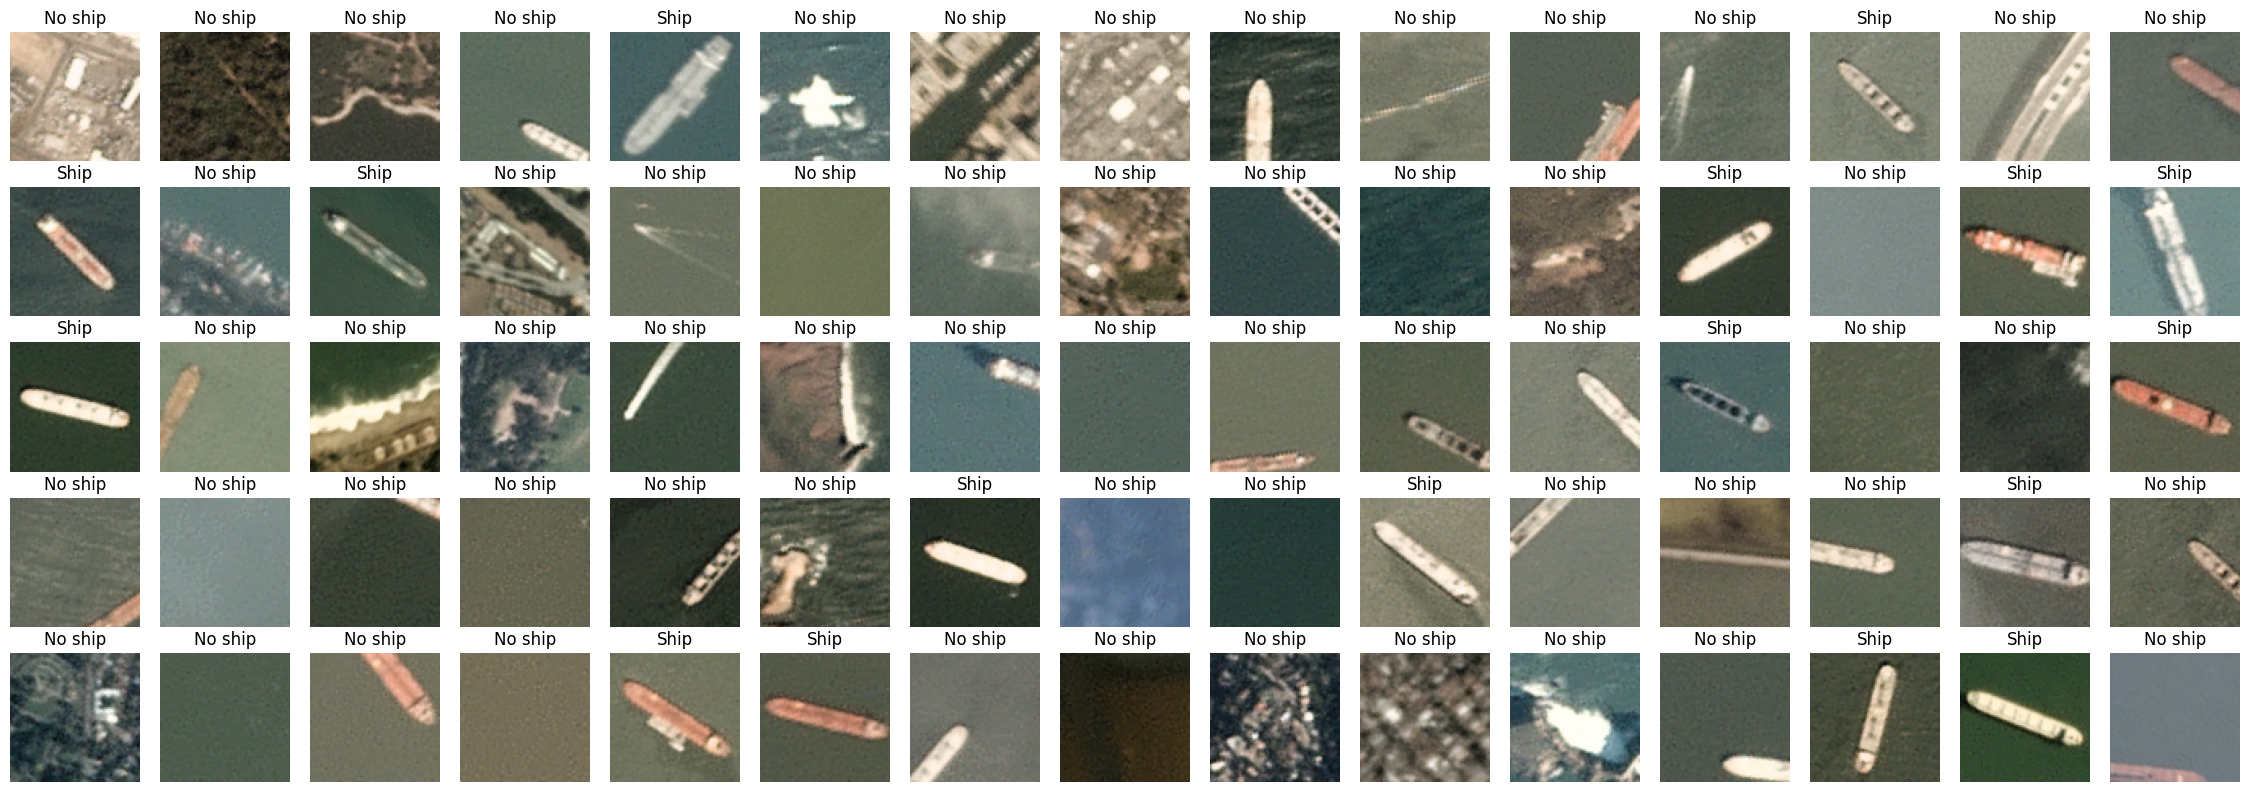

In [5]:
from DisplayUtils import plotImageGridClassification

r, c = 5, 15
plotShape = (r, c)
figsize = (c*1.5, r*1.5)

labelNames = {
    0: 'No ship',
    1: 'Ship'
}

randomIndices = np.random.choice(np.arange(len(df)), (r*c,), replace=False)
samples = [np.reshape(df['data'][i], (80, 80, 3), order='F') for i in randomIndices]
labels = [labelNames[df['labels'][i]] for i in randomIndices]

plotImageGridClassification(
    samples, 
    labels,
    plotShape=plotShape, 
    figsize=figsize, 
    subplots_adjust={
            'left': 0,
            'bottom': 0,
            'right': 1,
            'top': 1,
            'hspace': 0.2,
            'wspace': 0
    })

# Defining Training Infrastructure

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# First, get entire dataset into tensor format since the entire thing can fit into memory.
reshaped = df['data'].apply(lambda x: np.reshape(np.array(x), (3, 80, 80), order='F'))
X = np.stack(reshaped, axis=0)
print(f'Data shape: {X.shape}')
print(f'Data dtype: {X.dtype}')

Y = np.stack(df['labels'])
print(f'Labels shape: {Y.shape}')
print(f'Labels dtype: {X.dtype}')

fullDataset = TensorDataset(torch.Tensor(X), torch.Tensor(Y))

trainValTestSplit = [0.8, 0.1, 0.1]
trainDataset, validationDataset, testDataset = random_split(fullDataset, trainValTestSplit, generator=torch.Generator().manual_seed(42))

print(f'Train length: {len(trainDataset)}')
print(f'Validation length: {len(validationDataset)}')
print(f'Test length: {len(testDataset)}')

trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, pin_memory=True)
valLoader = DataLoader(validationDataset, batch_size=1, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=1, shuffle=False)

Data shape: (4000, 3, 80, 80)
Data dtype: int64
Labels shape: (4000,)
Labels dtype: int64
Train length: 3200
Validation length: 400
Test length: 400


## Sanity Check for DataLoader format

x.shape=(64, 3, 80, 80), y.shape=(64,)


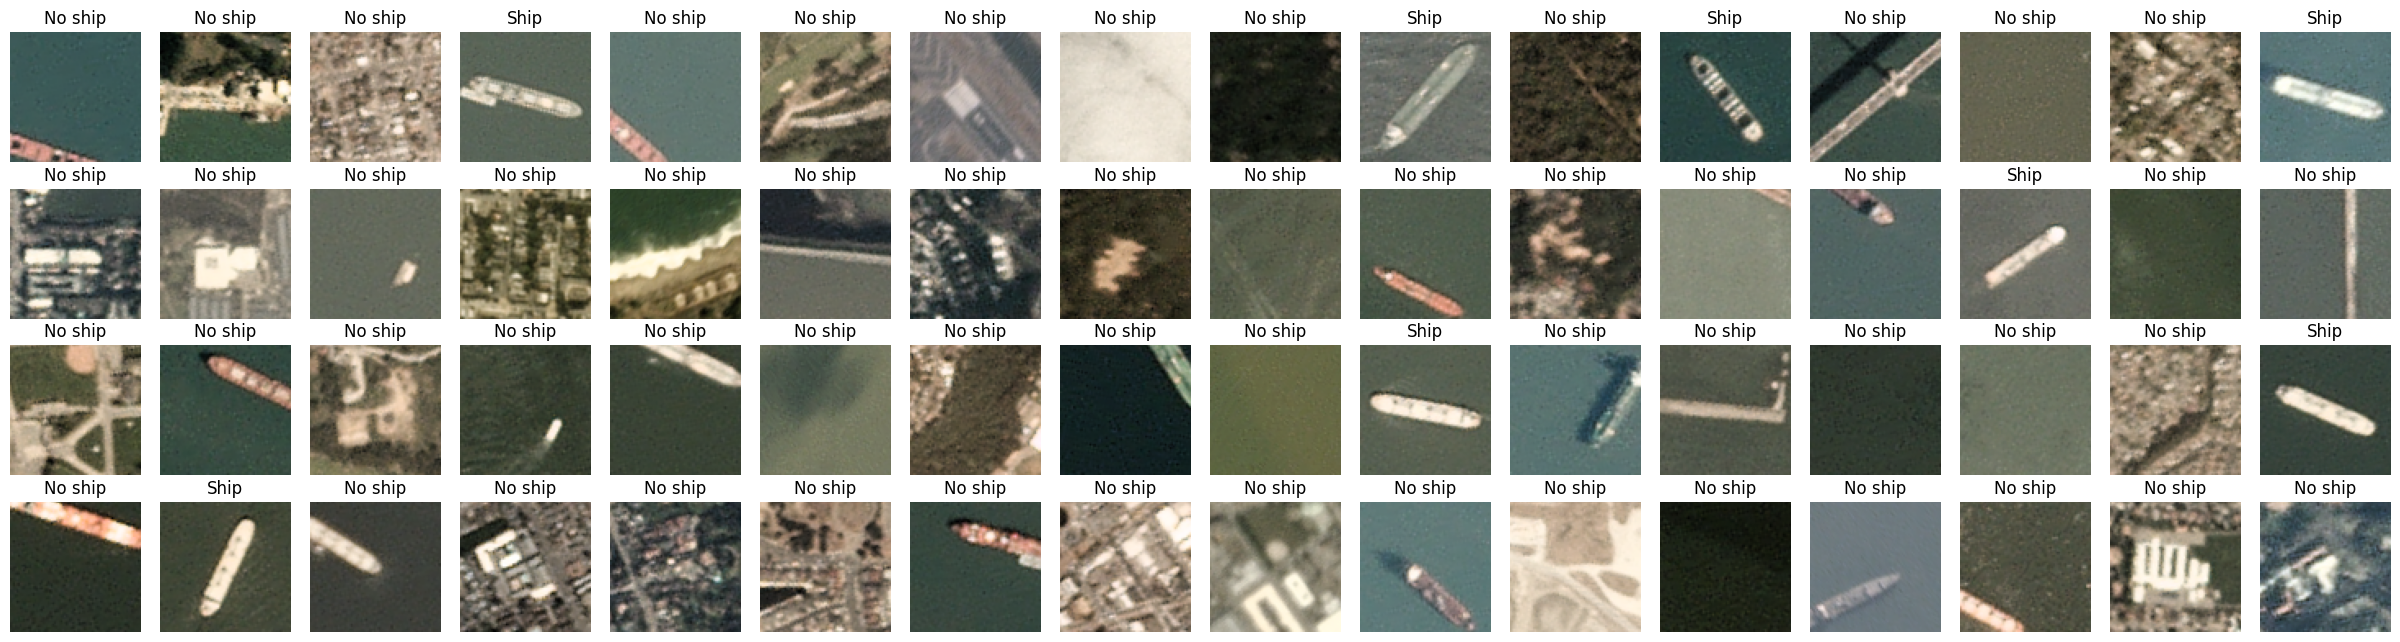

In [7]:
x, y = next(iter(trainLoader))
x: torch.Tensor
y: torch.Tensor
x, y = x.numpy().astype(np.int32), y.numpy().astype(np.int32)
print(f'{x.shape=}, {y.shape=}')

r, c = 4, 16
plotShape = (r, c)
figsize = (c*1.5, r*1.5)

labelNames = {
    0: 'No ship',
    1: 'Ship'
}

samples = [np.reshape(x[i], (80, 80, 3), order='F') for i in range(x.shape[0])]
labels = [labelNames[y[i]] for i in range(y.shape[0])]

plotImageGridClassification(
    samples, 
    labels,
    plotShape=plotShape, 
    figsize=figsize, 
    subplots_adjust={
            'left': 0,
            'bottom': 0,
            'right': 1,
            'top': 1,
            'hspace': 0.2,
            'wspace': 0
    })

# Getting normalization information about the dataset

In [8]:
from NormalizationUtils import getNormalizationStats
means, stds = getNormalizationStats(trainLoader)
print(f'{means=}')
print(f'{stds=}')

# The dataset is small enough to be normalized all at once, but we will
# normalize on the fly during training to work for extremely large datasets
# X = (X - means.reshape((1, means.shape[0], 1, 1))) / (stds.reshape((1, stds.shape[0], 1, 1)))

means=tensor([102.6732, 102.6739, 102.6721])
stds=tensor([43.0901, 43.0889, 43.0890])


# Recreate normalized datasets

In [52]:
from DataLoaders import getGPUDataLoader

reshaped = df['data'].apply(lambda x: np.reshape(np.array(x), (3, 80, 80), order='F'))
X = np.stack(reshaped, axis=0)
print(f'Data shape: {X.shape}')
print(f'Data dtype: {X.dtype}')

Y = np.stack(df['labels'])
print(f'Labels shape: {Y.shape}')
print(f'Labels dtype: {X.dtype}')

fullDataset = TensorDataset(torch.Tensor(X), torch.Tensor(Y).to(torch.int64))

trainValTestSplit = [0.8, 0.1, 0.1]
trainDataset, validationDataset, testDataset = random_split(fullDataset, trainValTestSplit, generator=torch.Generator().manual_seed(42))

print(f'Train length: {len(trainDataset)}')
print(f'Validation length: {len(validationDataset)}')
print(f'Test length: {len(testDataset)}')

trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, pin_memory=True)
# trainLoader = getGPUDataLoader(trainDataset, batch_size=64)
valLoader = DataLoader(validationDataset, batch_size=64, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=64, shuffle=False)

Data shape: (4000, 3, 80, 80)
Data dtype: int64
Labels shape: (4000,)
Labels dtype: int64
Train length: 3200
Validation length: 400
Test length: 400


# Model Architecture

In [60]:
import torch.nn as nn

baseNet = nn.Sequential(*[
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=8),
    
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=16),

    
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=32),


    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=64),


    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.BatchNorm2d(num_features=128),
    
    nn.Flatten(),
    
    nn.Linear(in_features=128, out_features=64),
    nn.ReLU(),
    nn.LayerNorm(normalized_shape=64),

    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.LayerNorm(normalized_shape=32),
    
    nn.Linear(in_features=32, out_features=2)
])

# baseNet = baseNet.to('cuda')
output = baseNet(next(iter(trainLoader))[0])
print(output.shape)

torch.Size([64, 2])


# Main Training Loop

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Train Batch Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Validation Batch Progress:   0%|          | 0/7 [00:00<?, ?it/s]

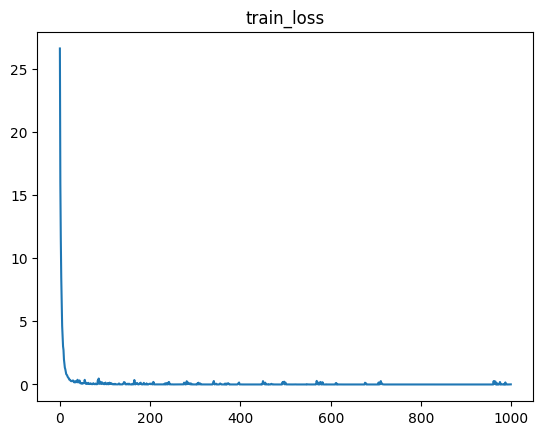

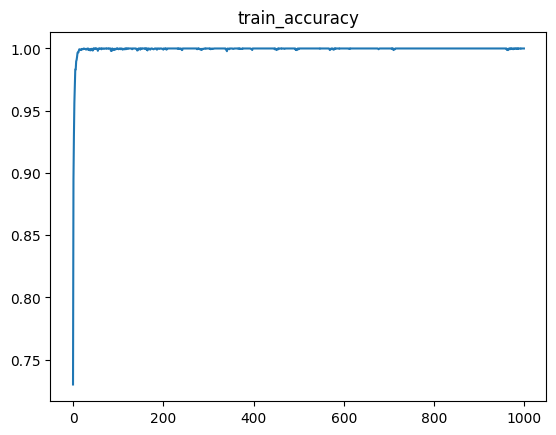

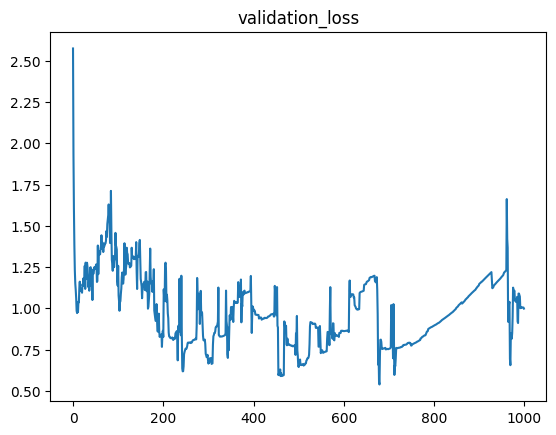

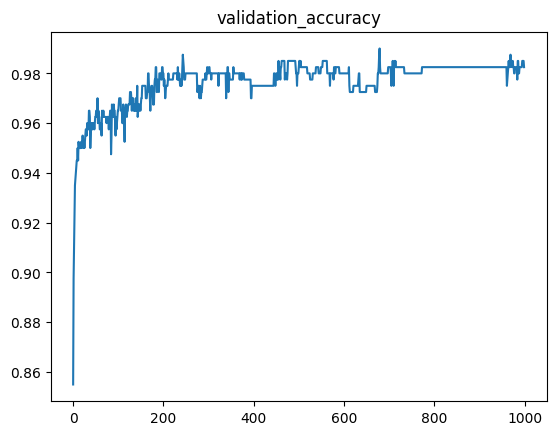

In [61]:
import torch.optim as optim
import tqdm
from contextlib import nullcontext

EPOCHS = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = baseNet.to(device)
lossFunction = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
STATS = {
    'train_loss': [],
    'train_accuracy': [],
    'validation_loss': [],
    'validation_accuracy': []
}

epoch_pbar = tqdm.notebook.tqdm(range(EPOCHS), position=0, leave=True, desc='Epochs')
train_batch_pbar = tqdm.notebook.tqdm(total=len(trainLoader), position=1, leave=True, desc='Train Batch Progress')
val_batch_pbar = tqdm.notebook.tqdm(total=len(valLoader), position=2, leave=True, desc='Validation Batch Progress')

def runEpoch(
    dataloader: DataLoader,
    pbar: tqdm.tqdm,
    statsTargets: dict,
    no_grad = False
):
    
    pbar.reset(total=len(dataloader))  # Reset while maintaining the total
    pbar.set_description(f'Epoch {e+1}')  # Update description to show current epoch
    numCorrect = 0
    numSamples = 0
    totalLoss = 0
    
    # Change context depending on whether we should compute gradients or not.
    context = torch.no_grad() if no_grad else nullcontext()
    with context:
        
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            
            if not no_grad:
                optimizer.zero_grad()
            
            y_hat = model(x)
            loss = lossFunction(y_hat, y)
            
            if not no_grad:
                loss.backward()
                optimizer.step()
            totalLoss += loss
            numCorrect += torch.sum(y == torch.argmax(y_hat, dim=1)).cpu()
            numSamples += x.shape[0]
            pbar.update(1)
            
        STATS[statsTargets['loss']].append(totalLoss.item())
        STATS[statsTargets['accuracy']].append(numCorrect/numSamples)

trainStatsTargets = {
    'loss': 'train_loss',
    'accuracy': 'train_accuracy'
}

validationStatsTargets = {
    'loss': 'validation_loss',
    'accuracy': 'validation_accuracy'
}

for e in epoch_pbar:
    runEpoch(
        dataloader=trainLoader, 
        pbar=train_batch_pbar, 
        statsTargets=trainStatsTargets
    )
    
    with torch.no_grad():
        runEpoch(
            dataloader=valLoader, 
            pbar=val_batch_pbar, 
            statsTargets=validationStatsTargets,
            no_grad=True
        )

    
train_batch_pbar.close()
val_batch_pbar.close()
epoch_pbar.close()

for k, v in STATS.items():
    plt.plot(v)
    plt.title(k)
    plt.show()